In [16]:
import numpy as np
from DataStructures.core import NumpyData
from DataStructures.generateBox import generate_grid_box
import matplotlib.pyplot as plt
import output as out
import simulation
import analysis
import pbc
plt.rcParams["figure.figsize"]=[9,6]
plt.rcParams.update({'font.size':12})
plt.rc("font",weight="bold")

In [17]:
# setup params SPC
epsilon = 0.1554253 * 4.184  #kJ/mol
sigma = 3.165492 #Å 
A = 4 * epsilon * sigma ** 12
B = 4 * epsilon * sigma ** 6
C = 1390   #kJ Å  / mol             
k = 1059.162 * 4.184   # kJ/mol Å**2   
eq_dist = 1.012 #Å
L = 14   #Å
T = 300   #Kelvin
dt = 0.001  # units of 100fs = 1dt
cell_dims = np.asarray([L,L,L])
g = 3.2                  #grid spacing
grid_spacings = np.asarray([g,g,g])
bond_length =  1  #Å
angle = 113.24/360 * 2 * np.pi
eq_angle = 113.24/360 * 2 * np.pi
k_theta = 75.90 * 4.184   # kJ/mol rad

#pairs of atomic number and expected mass/charge
charge_dict = {1:0.417,8:-0.834}
mass_dict = {1:1., 8:16.}

#make a example box of a grid of water-molecules with random orientations
test_box = generate_grid_box(cell_dims, grid_spacings, bond_length, angle, random_orientation=True)
N = test_box.get_elements().shape[0]
# setup atomic charges and masses
test_box.setup_charges(charge_dict)
test_box.setup_masses(mass_dict)
test_box.momenta = np.random.normal(0,0.0911837*np.sqrt(T/test_box.get_masses()[:, None]),(N,3))*test_box.get_masses()[:, None]



#technicalities
nbls = True
m_shake = False
m_shake_bond_eq = eq_dist
gamma = 0       #Coupling constant

#cutoff for the forcefield
rcut=8
print(N/3)


64.0


In [18]:
#Equilibration
steps_eq = 1000 
eq_result = simulation.simulate(test_box,A,B,C,k,eq_dist,k_theta,eq_angle,L,T,dt,steps_eq, 
                                nbls=nbls, m_shake=m_shake, bond_eq=m_shake_bond_eq, gamma=gamma, rcut=rcut)


100%|██████████| 1000/1000 [00:02<00:00, 379.04it/s]

0


In [19]:
#Production
steps_prod = 10000
test_box.momenta = np.random.normal(0,0.0911837*np.sqrt(T/test_box.get_masses()[:, None]),(N,3))*test_box.get_masses()[:, None]
result = simulation.simulate(test_box,A,B,C,k,eq_dist,k_theta,eq_angle,L,T,dt,steps_prod, 
                                nbls=nbls, m_shake=m_shake, bond_eq=m_shake_bond_eq, gamma=gamma, rcut=rcut)

100%|██████████| 10000/10000 [00:25<00:00, 398.35it/s]

0


In [20]:
#Create output file
dt_out = 10        # Output frequency
filename = 'Test'   # File name
box = test_box      #Universe
out.traj_to_pdb(dt_out,result[0],filename,box,N,dt,steps_prod,L,g,T)

In [21]:
energy = analysis.output_energy(result[0],result[1],test_box,1,A,B,C,k,eq_dist,k_theta,eq_angle,L,rcut)

Text(0.5, 1.0, 'NVT at 300')

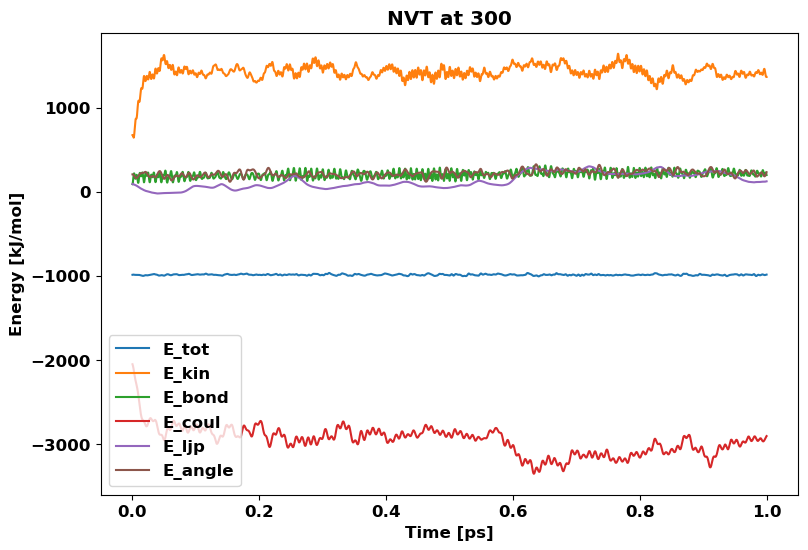

In [22]:
t = 100 * dt * steps_prod * 0.001   #Time in ps 
plt.plot(np.linspace(0,t,len(energy[0])),energy[0]+energy[1]+energy[2]+energy[3]+energy[4],label='E_tot')
plt.plot(np.linspace(0,t,len(energy[0])),energy[0],label='E_kin')
plt.plot(np.linspace(0,t,len(energy[0])),energy[3],label='E_bond')
plt.plot(np.linspace(0,t,len(energy[0])),energy[2],label='E_coul')
plt.plot(np.linspace(0,t,len(energy[0])),energy[1],label='E_ljp')
plt.plot(np.linspace(0,t,len(energy[0])),energy[4],label='E_angle')
plt.legend()
plt.xlabel("Time [ps]",weight="bold")
plt.ylabel("Energy [kJ/mol]",weight="bold")
plt.title("NVT at " + str(T),weight="bold")
#plt.ylim(0,100000)


Text(0.5, 1.0, 'NVT at 300')

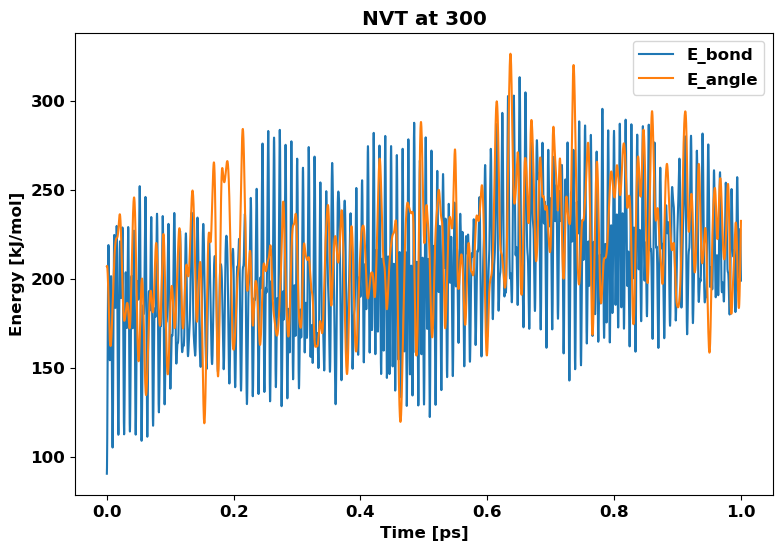

In [23]:
plt.plot(np.linspace(0,t,len(energy[0])),energy[3],label='E_bond')
#plt.plot(np.linspace(0,t,len(energy[0])),energy[1],label='E_ljp')
plt.plot(np.linspace(0,t,len(energy[0])),energy[4],label='E_angle')
plt.legend()
plt.xlabel("Time [ps]",weight="bold")
plt.ylabel("Energy [kJ/mol]",weight="bold")
plt.title("NVT at " + str(T),weight="bold")

Text(0.5, 1.0, 'NVT at 300')

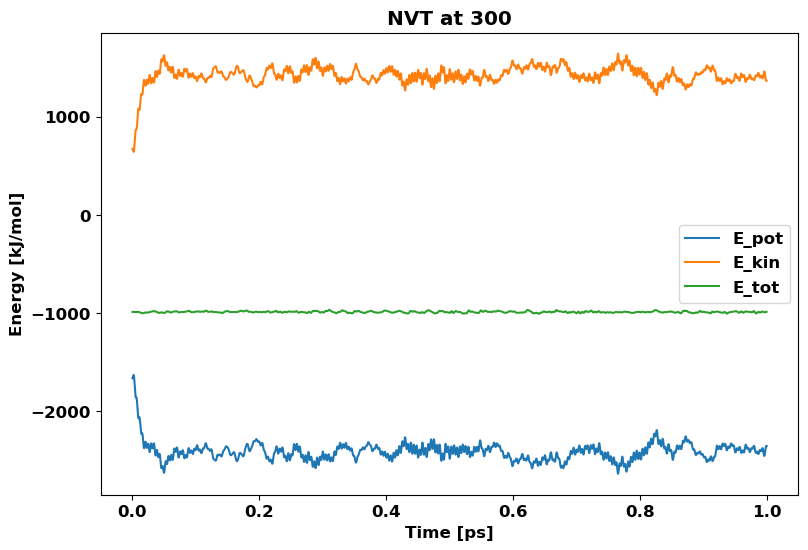

In [24]:
plt.plot(np.linspace(0,t,len(energy[0])),energy[1]+energy[2]+energy[3]+energy[4],label='E_pot')
plt.plot(np.linspace(0,t,len(energy[0])),energy[0],label='E_kin')
plt.plot(np.linspace(0,t,len(energy[0])),energy[0]+energy[1]+energy[2]+energy[3]+energy[4],label='E_tot')
plt.legend()
plt.xlabel("Time [ps]",weight="bold")
plt.ylabel("Energy [kJ/mol]",weight="bold")
plt.title("NVT at " + str(T),weight="bold")

In [25]:
distr = analysis.bond_angle_distribution(result[0],test_box,L,100)

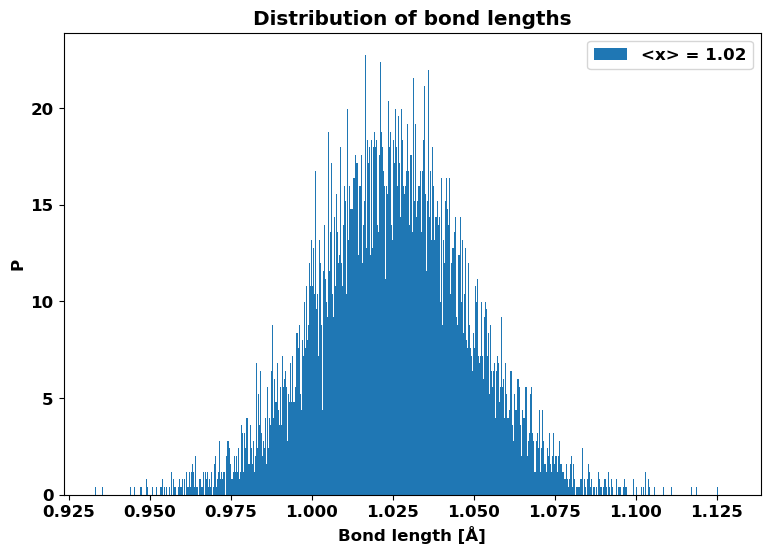

In [26]:
_=plt.hist(distr[0],1000,density=True,log=False,label="<x> = "+str(np.round(distr[0].mean(),2)))
plt.xlabel("Bond length [Å]",weight="bold")
plt.ylabel("P",weight="bold")
plt.title("Distribution of bond lengths",weight="bold")
plt.legend()

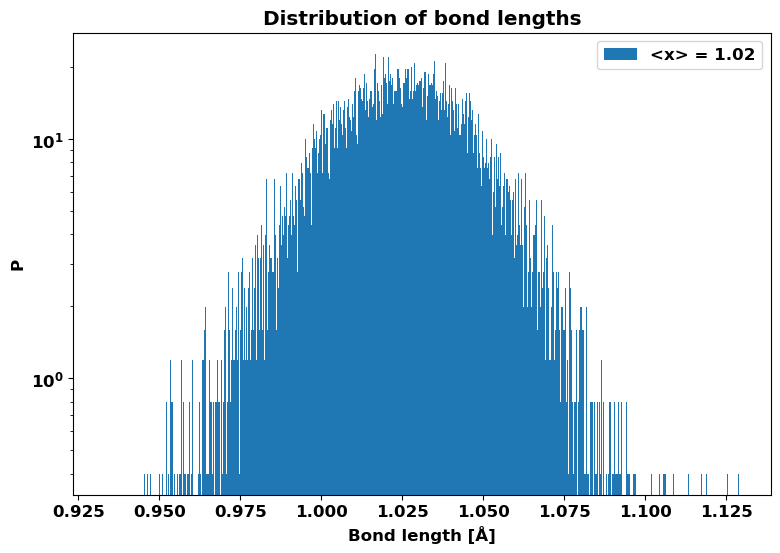

In [27]:
_=plt.hist(distr[0],1000,density=True,log=True,label="<x> = "+str(np.round(distr[0].mean(),2)))
plt.xlabel("Bond length [Å]",weight="bold")
plt.ylabel("P",weight="bold")
plt.title("Distribution of bond lengths",weight="bold")
plt.legend()

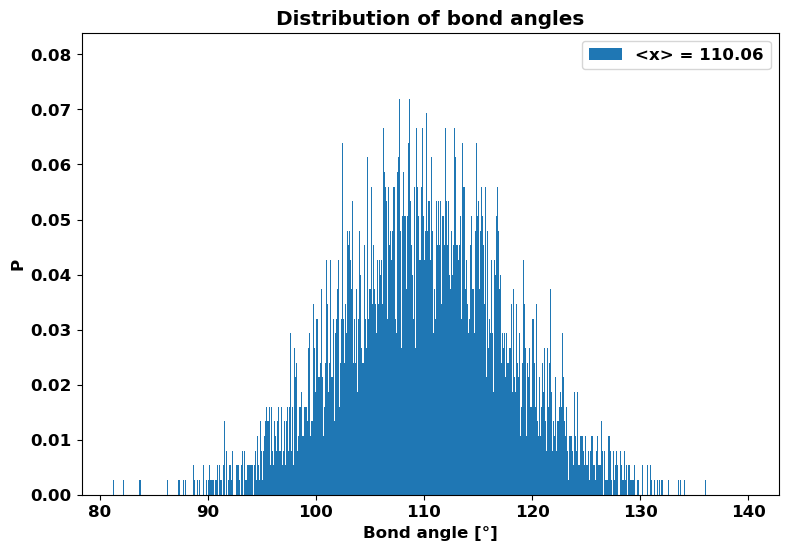

In [28]:
_=plt.hist(distr[1]*360 / (2*np.pi),1000,density=True,log=False,label="<x> = "+str(np.round(distr[1].mean()*360 / (2*np.pi),2)))
plt.xlabel("Bond angle [°]",weight="bold")
plt.ylabel("P",weight="bold")
plt.title("Distribution of bond angles",weight="bold")
plt.legend()

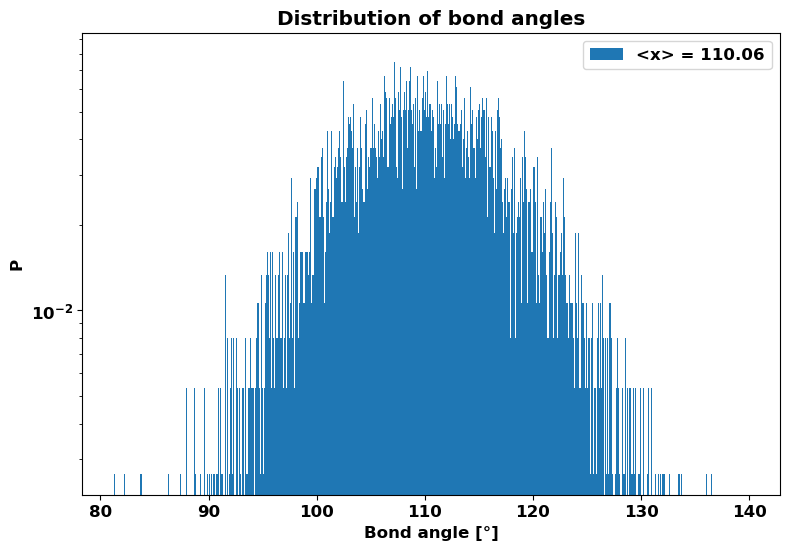

In [29]:
_=plt.hist(distr[1]*360 / (2*np.pi),1000,density=True,log=True,label="<x> = "+str(np.round(distr[1].mean()*360 / (2*np.pi),2)))
plt.xlabel("Bond angle [°]",weight="bold")
plt.ylabel("P",weight="bold")
plt.title("Distribution of bond angles",weight="bold")
plt.legend()

Text(0.5, 1.0, 'Distribution of potential energy')

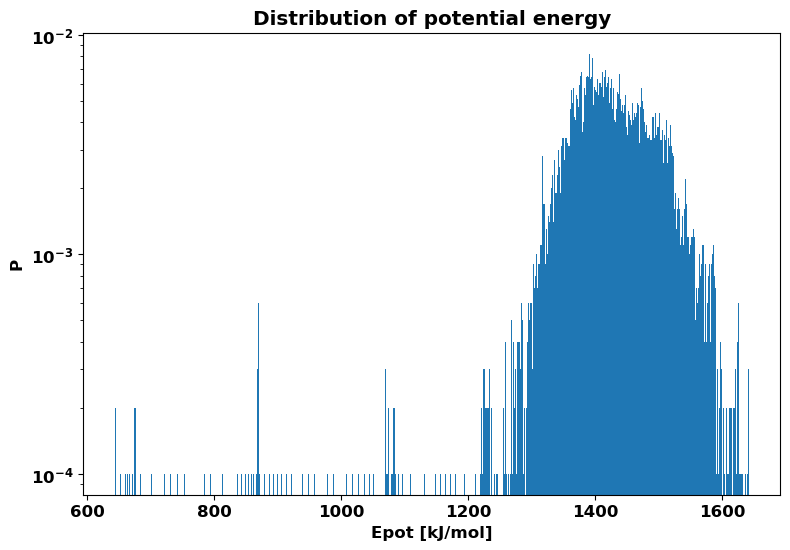

In [32]:
_=plt.hist(energy[0],1000,density=True,log=True,label="<x> = ")
plt.xlabel("Epot [kJ/mol]",weight="bold")
plt.ylabel("P",weight="bold")
plt.title("Distribution of potential energy",weight="bold")
#plt.legend()